In [124]:
import pandas as pd
import numpy as np
import json
from datetime import datetime as dt
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

<h5>Cleaning up Yahoo data</h5>

In [2]:
def clean_yahoo_df(path):
    ticker = path.split('/')[-1].split('.')[0]
    df = pd.read_csv(path)
    
    df.drop(['High','Low','Open','Close'], axis=1, inplace=True)
    df['Adj Close'] = df['Adj Close'].round(2)
    #df['Volume'] = df['Volume'].astype('int32')
    df.rename(columns={'Volume': f'{ticker}_volume', 'Adj Close': ticker}, inplace=True)
    df.set_index('Date', inplace=True)
    
    return df

In [3]:
main_df = clean_yahoo_df('final_dfs/spy.csv')
main_df.head()

,spy_volume,spy
Date,,
1993-01-29,1003200.0,26.30
1993-02-01,480500.0,26.49
1993-02-02,201300.0,26.54
1993-02-03,529400.0,26.82
1993-02-04,531500.0,26.94


A few economic indicators are updated weekly, monthly, etc. Some of those days are on the weekend when equity markets are not opened. For that, we will have to outer join those dataframes with the main dataframes, forward fill the NaN data, and remove weekend dates. Below is the list of SPY dates that will be used later.

In [4]:
spy_dates = list(main_df.index)

Below are all tickers pulled from Yahoo and saved locally. I will need to find a way to automate the refresh daily but for now will use the data I have to optimize the model.

Also note, for the individual sector ETFs, I will use Vanguard ETFs instead of SPDR even if SPY is an SPDR ETFs. Even though most of the SPDR ETFs are larger and more liquid I find the Vanguard ETFs more accurately reflects their respective idustries as the portfolios include small and mid caps. SPDR ETFs are heavily concentrated in stocks already included in SPY.

In [5]:
# note: leaving out USO becuase we have /CL

etfs = ['qqq', 'iwm']

sector_etf_path = 'sector etfs - Vanguard'
sector_etf = ['vaw', 'vcr', 'vdc', 'vde', 'vfh', 'vgt', 'vht', 'vis', 'vnq', 'vox', 'vpu']

futures_path = 'futures'
futures = ['cl=f', 'gc=f']

bonds_etf_path = 'bonds etfs'
bonds = ['ief', 'tlt']

In [6]:
for ticker in etfs:
    temp_df = clean_yahoo_df(f'final_dfs/{ticker}.csv')
    main_df = main_df.join(temp_df, how='left')

for ticker in sector_etf:
    temp_df = clean_yahoo_df(f'final_dfs/{sector_etf_path}/{ticker}.csv')
    main_df = main_df.join(temp_df, how='left')

for ticker in futures:
    temp_df = clean_yahoo_df(f'final_dfs/{futures_path}/{ticker}.csv')
    main_df = main_df.join(temp_df, how='left')
    
for ticker in bonds:
    temp_df = clean_yahoo_df(f'final_dfs/{bonds_etf_path}/{ticker}.csv')
    main_df = main_df.join(temp_df, how='left')

In [7]:
main_df.head()

,spy_volume,spy,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,...,vpu_volume,vpu,cl=f_volume,cl=f,gc=f_volume,gc=f,ief_volume,ief,tlt_volume,tlt
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,1003200.0,26.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,480500.0,26.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,201300.0,26.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,529400.0,26.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,531500.0,26.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h5>Other charts (Treasure bond yields, Libor rate, Mortgage rate, M1 & M2 money supply, VIX, DIX)</h5>
<br>
Data pulled from various sources.

In [8]:
# maybe include VVIX in the future?
# Notes:
# 30 year fixed mortgage rate is updated monthly (need may numbers)
# money supply data is updated weekly

economics_path = 'economics'
economics = ['CPIAUCSL', 'DFF', 'DGS10', 'DGS30', 'M1', 'M2', 'MORTGAGE15US', 'MORTGAGE30US',
             'T10YIE', 'UNRATE', 'USD1MTD156N', 'USD6MTD156N', 'USD12MD156N']
economic_names = ['CPI', 'fed_funds_rate', '10_yr_treasury', '30_yr_treasury', 'M1_supply',
                  'M2_supply', '15_yr_mortgage', '30_yr_mortgage', '10_yr_inflation',
                  'unemployment', '1m_libor', '3m_libor', '12m_libor']

currency_path = 'currency'
currency = ['dxy']

vix = '^vix'
dix = 'DIX'

In [9]:
# economic data
for code, name in zip(economics, economic_names):
    try:
        economics_df = pd.read_csv(f'final_dfs/{economics_path}/{code}.csv')
        economics_df = economics_df.loc[economics_df['DATE'] >= '1993-01-01']
        economics_df.rename(columns={code: name}, inplace=True)
        economics_df.set_index('DATE', inplace=True)
        if code in ['M1_supply', 'M2_supply']:
            economics_df = economics_df * 1000000000
        elif code == 'GFDEBTN':
            economics_df = economics_df * 1000000
        elif code == 'CPIAUCSL':
            economics_df
        else:
            economics_df = economics_df / 100
    except:
        economics_df.replace('.', np.nan, inplace=True)
        economics_df.ffill(inplace=True)
        economics_df = economics_df.astype(float)
        economics_df = economics_df / 100
    main_df = main_df.join(economics_df, how='outer')

# currency (check date format)
currency_df = pd.read_csv(f'final_dfs/{currency_path}/{currency[0]}.csv')
currency_df.drop([' Open',' High',' Low'], axis=1, inplace=True)
currency_df.rename(columns={' Close': currency[0]}, inplace=True)
currency_df['Date'] = currency_df['Date'].apply(lambda x: dt.strptime(x, '%m/%d/%y').strftime('%Y-%m-%d'))
currency_df.set_index('Date', inplace=True)
main_df = main_df.join(currency_df, how='left')

# vix
vix_df = clean_yahoo_df(f'final_dfs/{vix}.csv')
vix_df.drop('^vix_volume', axis=1, inplace=True)
main_df = main_df.join(vix_df, how='left')

# dix
dix_df = pd.read_csv(f'final_dfs/{dix}.csv')
dix_df.drop('price', axis=1, inplace=True)
dix_df.set_index('date', inplace=True)
main_df = main_df.join(dix_df, how='left')

In [10]:
main_df.head(3)

,spy_volume,spy,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,...,30_yr_mortgage,10_yr_inflation,unemployment,1m_libor,3m_libor,12m_libor,dxy,^vix,dix,gex
1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Forward fill any data that is updated weekly, monthly, etc. Remove all dates when market is closed (weekends, holidays).

In [11]:
main_df.ffill(inplace=True)

In [12]:
main_df = main_df[main_df.index.isin(spy_dates)]
main_df.head()

,spy_volume,spy,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,...,30_yr_mortgage,10_yr_inflation,unemployment,1m_libor,3m_libor,12m_libor,dxy,^vix,dix,gex
1993-01-29,1003200.0,26.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0786,NaN,0.073,0.031250,0.033672,0.036875,92.48,12.42,NaN,NaN
1993-02-01,480500.0,26.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0786,NaN,0.071,0.031250,0.033750,0.036875,93.39,12.33,NaN,NaN
1993-02-02,201300.0,26.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0786,NaN,0.071,0.031875,0.034375,0.037500,93.94,12.25,NaN,NaN
1993-02-03,529400.0,26.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0786,NaN,0.071,0.031875,0.034375,0.037500,94.33,12.12,NaN,NaN
1993-02-04,531500.0,26.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0786,NaN,0.071,0.031875,0.034375,0.037500,94.33,12.29,NaN,NaN


<h5>Handling Null Values</h5>
<br>
I have decided to drop any rows with NaN. DIX/GEX data had the most NaN values since it was not recorded until 2011. I could just remove the columns but the main purpose of this project was to see how accurate the DIX index was at predicting SPY prices so I left it in.
<br>
Will do another analysis without DIX/GEX. When that happens we will have data from ~2004

In [13]:
main_df.isna().sum().sort_values(ascending=False).head(5)

gex           4598
dix           4598
vox           2939
vox_volume    2939
vnq           2939
dtype: int64

In [14]:
main_df = main_df.dropna(axis=0)
main_df.index = pd.to_datetime(main_df.index,format='%Y-%m-%d')
main_df.head()

,spy_volume,spy,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,...,30_yr_mortgage,10_yr_inflation,unemployment,1m_libor,3m_libor,12m_libor,dxy,^vix,dix,gex
2011-05-02,126278700.0,113.55,48149400.0,53.57,48962400.0,74.88,59000.0,74.33,119000.0,58.26,...,0.0478,0.0256,0.09,0.002102,0.004305,0.007610,72.95,15.99,0.378842,1.897313e+09
2011-05-03,138375000.0,113.14,38100000.0,53.31,56070000.0,73.94,65800.0,73.38,40400.0,58.00,...,0.0478,0.0255,0.09,0.002095,0.004302,0.007578,73.14,16.70,0.383411,1.859731e+09
2011-05-04,182678500.0,112.39,53097200.0,53.23,64754600.0,72.98,89000.0,72.09,26000.0,57.78,...,0.0478,0.0255,0.09,0.002090,0.004285,0.007562,73.03,17.08,0.392122,1.717764e+09
2011-05-05,226900000.0,111.37,72200000.0,52.94,91858900.0,72.65,89400.0,71.42,26300.0,57.68,...,0.0471,0.0248,0.09,0.002062,0.004270,0.007520,74.19,18.20,0.405457,1.361864e+09
2011-05-06,222787200.0,111.86,72507000.0,53.11,76446200.0,73.03,101100.0,71.95,23800.0,57.80,...,0.0471,0.0248,0.09,0.002038,0.004250,0.007490,74.84,18.40,0.418649,1.490329e+09


In [15]:
cols_to_normalize = []
for i in main_df.columns:
    if main_df[i].iloc[0] >= 1:
        cols_to_normalize.append(i)
    #print(i, main_df[i].iloc[0])
cols_to_normalize.remove('spy')

<h5>Last Value Method</h5>
We will be shifiting the target value up by one day, meaning we will set the current adjusted closing price as the previous day's adjusted closing price

In [19]:
main_df['spy_shift_1d'] = main_df['spy'].shift(-1)
main_df.drop(main_df.tail(1).index, inplace=True)
main_df.drop('spy', axis=1, inplace=True)

In [60]:
main_df.tail(3)

,spy_volume,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,vdc_volume,...,10_yr_inflation,unemployment,1m_libor,3m_libor,12m_libor,dxy,^vix,dix,gex,spy_shift_1d
2020-04-27,77896600.0,36451700.0,215.56,39021300.0,127.26,83200.0,109.09,200600.0,173.22,451600.0,...,0.0117,0.147,0.004376,0.008931,0.009251,100.04,33.29,0.432132,1.284878e+09,285.73
2020-04-28,105270000.0,46862800.0,211.50,47292700.0,129.11,56100.0,111.16,75600.0,173.41,141600.0,...,0.0114,0.147,0.004036,0.008619,0.009097,99.86,33.57,0.440944,9.315513e+08,293.21
2020-04-29,118745600.0,48716400.0,219.00,50390500.0,135.46,106800.0,114.60,73400.0,178.42,164800.0,...,0.0114,0.147,0.003701,0.008049,0.008986,99.56,31.23,0.445038,2.502561e+09,290.48


<h5>Normalizing Data</h5>

In [43]:
temp_df = main_df[cols_to_normalize].copy()

In [59]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
main_df_scaled = pd.DataFrame(scalar.fit_transform(temp_df), columns=cols_to_normalize, index=main_df.index)
main_df_scaled = main_df_scaled.join(main_df.loc[:,~main_df.columns.isin(cols_to_normalize)])
main_df_scaled.head(3)

,spy_volume,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,vdc_volume,...,30_yr_treasury,15_yr_mortgage,30_yr_mortgage,10_yr_inflation,unemployment,1m_libor,3m_libor,12m_libor,dix,spy_shift_1d
2011-05-02,0.151971,0.198375,0.042005,0.235542,0.182481,0.02027,0.256841,0.061954,0.067085,0.026170,...,0.0438,0.0397,0.0478,0.0256,0.09,0.002102,0.004305,0.007610,0.378842,113.14
2011-05-03,0.169312,0.149835,0.040643,0.269736,0.174321,0.02289,0.245826,0.017685,0.065421,0.028992,...,0.0436,0.0397,0.0478,0.0255,0.09,0.002095,0.004302,0.007578,0.383411,112.39
2011-05-04,0.232824,0.222274,0.040224,0.311515,0.165987,0.03183,0.230867,0.009575,0.064012,0.036975,...,0.0433,0.0397,0.0478,0.0255,0.09,0.002090,0.004285,0.007562,0.392122,111.37


In [57]:
features = [i for i in main_df.columns if i != 'spy_shift_1d']
target = 'spy_shift_1d'

In [61]:
valid_test_size = int(len(main_df) * 0.2)
train_size = len(main_df) - valid_test_size - valid_test_size

train = main_df.iloc[:train_size].copy()
valid = main_df.iloc[train_size:train_size+valid_test_size].copy()
train_valid = main_df.iloc[:train_size+valid_test_size].copy()
test = main_df.iloc[train_size+valid_test_size:].copy()

train_scaled = main_df_scaled.iloc[:train_size].copy()
valid_scaled = main_df_scaled.iloc[train_size:train_size+valid_test_size].copy()
train_valid_scaled = main_df_scaled.iloc[:train_size+valid_test_size].copy()
test_scaled = main_df_scaled.iloc[train_size+valid_test_size:].copy()

<h5>Splitting features and targets</h5>

In [118]:
# non-scaled data

X_train = train[features]
X_valid = valid[features]
X_train_valid = train_valid[features]
X_test = test[features]


y_train = train[target]
y_valid = valid[target]
y_train_valid = train_valid[target]
y_test = test[target]

print('Features')
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'X_train_valid shape: {X_train_valid.shape}')
print(f'X_test shape: {X_test.shape}')

print('\nTargets')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')
print(f'y_train_valid shape: {y_train_valid.shape}')
print(f'y_test shape: {y_test.shape}')

Features
X_train shape: (1360, 52)
X_valid shape: (452, 52)
X_train_valid shape: (1812, 52)
X_test shape: (452, 52)

Targets
y_train shape: (1360,)
y_valid shape: (452,)
y_train_valid shape: (1812,)
y_test shape: (452,)


In [85]:
# scaled data

X_train_scaled = train_scaled[features]
X_valid_scaled = valid_scaled[features]
X_train_valid_scaled = train_valid_scaled[features]
X_test_scaled = test_scaled[features]

print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'y_train_scaled shape: {y_train_scaled.shape}')
print(f'X_valid_scaled shape: {X_valid_scaled.shape}')
print(f'y_valid_scaled shape: {y_valid_scaled.shape}')
print(f'X_train_valid_scaled shape: {X_train_valid_scaled.shape}')
print(f'y_train_valid_scaled shape: {y_train_valid_scaled.shape}')
print(f'X_test shape_scaled: {X_test_scaled.shape}')
print(f'y_test shape_scaled: {y_test_scaled.shape}')

X_train_scaled shape: (1360, 52)
y_train_scaled shape: (1360,)
X_valid_scaled shape: (452, 52)
y_valid_scaled shape: (452,)
X_train_valid_scaled shape: (1812, 52)
y_train_valid_scaled shape: (1812,)
X_test shape_scaled: (452, 52)
y_test shape_scaled: (452,)


<h5>Model using XGBoost</h5>

In [89]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math

model = XGBRegressor(n_estimators=100,
                     max_depth=3,
                     learning_rate=0.1,
                     gamma=0,
                     min_child_weight=1,
                     subsample=1,
                     colsample_bytree=1,
                     colsample_by_level=1,
                     random_state=0)

model.fit(X_train_scaled, y_train)

[20:12:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { colsample_by_level } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_by_level=1,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<h5>Predicting Training Set</h5>

In [110]:
train_predict = model.predict(X_train_scaled)

print(f'RMSE: {math.sqrt(mean_squared_error(y_train, train_predict))}')

RMSE: 1.0200844667766078


[]

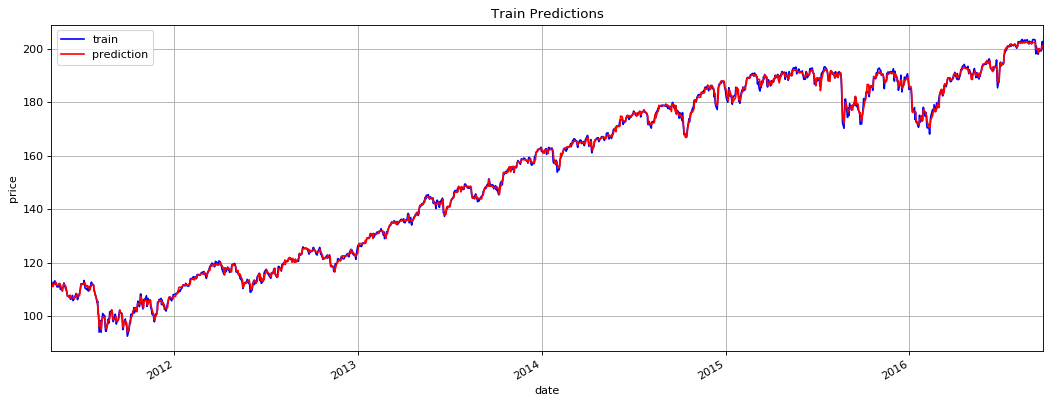

In [178]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

train_predict_df = pd.DataFrame({'predict': train_predict}, index=y_train.index)

ax = y_train.plot(style='b', grid=True)
ax = train_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['train', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Train Predictions')

plt.plot()

In [ ]:
# train model on validation data next

In [23]:
# notes
# CPI needs April data
# MI & M2 missing last week of April data
# explore adding options data if possible
# add industry ticker data and volume
# build funciton to find optimal parameters
# train model for validation/test sets
# find a way to predict trend data (trend line for week/month out)